<html>
  <body>

  <p align="center"><img src="https://cdn-07.9rayti.com/rsrc/cache/widen_224/uploads/2012/07/ensias.png" alt="logo ensias" width="180" height="165"/>
</p>

<p align="center"><b><font size="5">RSA Benchmarking : CPU vs GPU </font></b></p>


---


<br>
<font size="3">
<b>Description :</b>	
<font size="3">
In this Project we implemented 'RSA' Algorithm which is an asymmetric encryption system that is widely used for secure data transmission. We divided the algorithm into three parts: generation of pair of prime number, calculate public and private keys, finally encryption and decryption of a text. We used Python as a programming language and Cuda as a framework for GPU code then we run everything on Google Collab (https://colab.research.google.com) which has a Tesla K4 GPU.
</font>		


---

<font size="2">
<I><b>Supervised by our dear Professor :</b> Meryeme Ayache <br>
<b>Presented by :</b> Rania Aichi - Karim Bouanane - Zakariae Hamedoun </I>
</font>
<br>
<br>


</body>
</html>


# Dependencies

In [ ]:
!pip install gmpy2

In [2]:
# Dependencies
from math import sqrt, ceil, gcd
from numba import cuda
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import timeit
import gmpy2

# Generate pairs of prime numbers

In [3]:
def is_prime_cpu(num, limit):
  # Returns True if the number is prime else False.
  for x in range(3, limit, 2):
    if num % x == 0:
      return False
  return True

def checkPrime_CPU(number):
  if number % 2 != 0:
    limit = ceil(sqrt(number))

    cpu_starttime = timeit.default_timer()
    isprime = is_prime_cpu(number, limit)
    cpu_check_time = timeit.default_timer() - cpu_starttime
    
    if isprime == True:
      return cpu_check_time
  return False

In [4]:
@cuda.jit
def is_prime_gpu(num, limit, flag):
  thread_position = cuda.grid(1) * 2 + 3
  if thread_position < limit:
      if num % thread_position == 0:
        flag[0] = False

def checkPrime_GPU(number):
  if number % 2 != 0:
    flag = np.array([True])
    limit = ceil(sqrt(number))
    totalThreads = ceil((limit-2)/2)
    numBlocks = ceil(totalThreads / 1024.0)
    blockDim = 1024
    
    gpu_starttime = timeit.default_timer()
    is_prime_gpu[numBlocks, blockDim](number, limit, flag)
    gpu_check_time = timeit.default_timer() - gpu_starttime

    if flag[0] == True:
      return gpu_check_time

  return False

In [5]:
def getPrimeNumber(bitLength):
  # Returns a prime number of the specified bit length.
  while True:
    number = random.getrandbits(bitLength)
    # CPU check
    c = checkPrime_CPU(number)
    if c != False:
      # GPU check
      g = checkPrime_GPU(number)
      return {'number': number, 'cpuTime': c, 'gpuTime': g}

def generatePairPrime(keySize):
  # keysize is the bit length of n = p * q
  result = {}
  p_size = q_size = keySize // 2
  if keySize % 2 != 0:
    q_size += 1
  
  res_p = getPrimeNumber(p_size)
  res_q = getPrimeNumber(q_size)
  result['pairPrime'] = (res_p['number'] , res_q['number'])
  result['cpuTime'] = res_p['cpuTime'] + res_q['cpuTime']
  result['gpuTime'] = res_p['gpuTime'] + res_q['gpuTime']
  return result

## Plot performance results

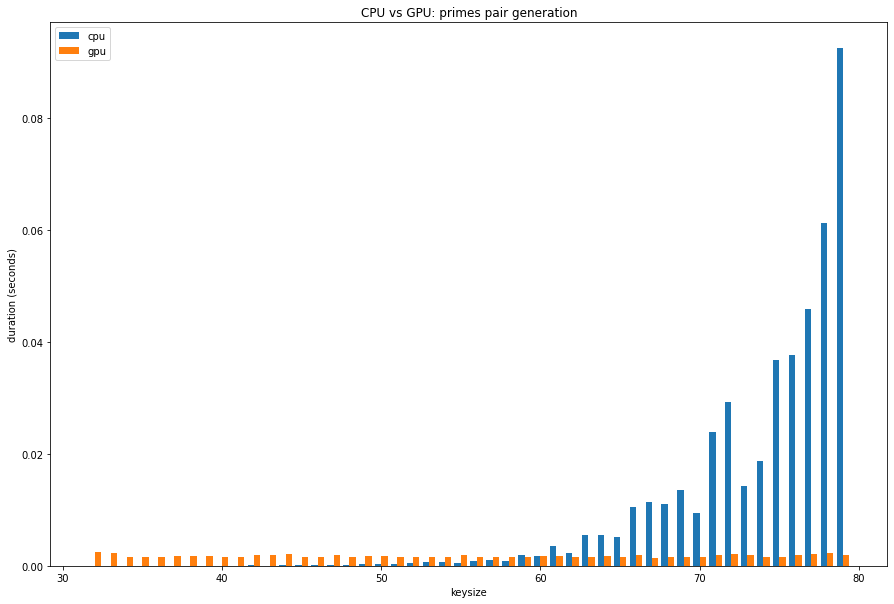

In [7]:
x_axis = np.arange(32,80)
y_cpu = []
y_gpu = []

for y in x_axis:
  # get pairs of prime numbers with cpu checking time
  # and gpu checking time
  res = generatePairPrime(y)
  y_cpu.append(res['cpuTime'])
  y_gpu.append(res['gpuTime'])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.bar(x_axis-0.2, y_cpu, width = 0.4, label = "cpu")
plt.bar(x_axis+0.2, y_gpu, width = 0.4, label = "gpu")

plt.xlabel('keysize')
plt.ylabel('duration (seconds)')
plt.title('CPU vs GPU: primes pair generation')
plt.legend()
plt.show()

# 2. Generate public & private keys

> ## Private key : d

In [8]:
def findD(e, phi):
  # The private key d has to satisfy this condition (d * e) % phi = 1
  return int(gmpy2.divm(1, e, phi))

def getPrivateKey(e, phi):
  d = findD(e, phi)
  return d

> ## Public key : e

In [9]:
def is_coprime(x,y):
  return gcd(x,y) == 1

def findE(n, phi):
  # public key "e" must be greater than 1 and less than the phi = (p-1)(q-1). 
  # It also has to be co-prime with modulus, and fi function 
  while True:
      e = random.randrange(2, phi)
      if is_coprime(e, n) == True and is_coprime(e, phi) == True:
        break
  return e

def getPublicKey(n, phi):
  e = findE(n, phi)
  return e

> ## Keys (n,e), (n,d)

In [10]:
def getRSAKeys(keySize):
  res = generatePairPrime(keySize)
  p = res['pairPrime'][0]
  q = res['pairPrime'][1]
  n =  p * q
  phi = (p-1)*(q-1)
  e = getPublicKey(n, phi)
  d = getPrivateKey(e, phi)
  return ((n,e), (n,d))

In [11]:
getRSAKeys(64)

((10514499886446081739, 9663441214951930261),
 (10514499886446081739, 2430174453680291341))

# 3. Encryption/Decryption

## The Encryption Function
$C = P^e*mod(n)$
<br>
* C : The Crypted Message (**C**hipertext)
* P : The Original Message (**P**laintext)

In [21]:
message = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore."

In [13]:
def encrypt_cpu(msg_plaintext, pubKey):
  n, e = pubKey
  msg_ciphertext = [pow(ord(c), e, n) for c in msg_plaintext]
  return msg_ciphertext

@cuda.jit
def encrypt_gpu(msg_ciphertext, msg_plaintext, msg_length, n, e):
  thread_position = cuda.grid(1)
  if( thread_position < msg_length):
    #n, e = pubKey
    c = msg_plaintext[thread_position]
    #msg_ciphertext[thread_position] = (ord(c)**e) % n #pow(ord(c), e, n)
    msg_ciphertext[thread_position] = (c**e) % n

In [14]:
def getEncryptedMssg_cpu(msg_plaintext, pubKey):
  result = {}
  encryptCPUStartTime = timeit.default_timer()
  msg_ciphertext = encrypt_cpu(msg_plaintext, pubKey)
  encryptCPUDuration = timeit.default_timer() - encryptCPUStartTime
  
  result['cpuTime'] = encryptCPUDuration
  result['encryptedMssg'] = msg_ciphertext
  return result

def getEncryptedMssg_gpu(msg_plaintext, pubKey):
  result = {}
  n,e = pubKey
  msg_length = len(msg_plaintext)
  msg_ciphertext = np.zeros(msg_length)
  msg_origintext = np.array([ord(c) for c in msg_plaintext])

  # setup kernel configuration
  totalThreads = msg_length
  numBlocks = ceil(totalThreads / 1024.0)
  blockDim = 1024

  # use public key to encrypt message
  encryptGPUStartTime = timeit.default_timer()
  encrypt_gpu[numBlocks, blockDim](msg_ciphertext, msg_origintext, msg_length, n, e)
  encryptGPUDuration = timeit.default_timer() - encryptGPUStartTime

  result['gpuTime'] = encryptGPUDuration
  result['encryptedMssg'] = msg_ciphertext
  return result

## The Decryption Function
$P = C^d*mod(n)$
<br>
* P : The Original Message (**P**laintext)
* C : The Crypted Message (**C**hipertext)

In [38]:
def decrypt_cpu(msg_ciphertext, privKey):
  n, d = privKey
  msg_plaintext = [chr(pow(c, d, n)) for c in msg_ciphertext]
  # No need to use ord() since c is now a number
  # After decryption, we cast it back to character
  # to be joined in a string for the final result
  return (''.join(msg_plaintext))

@cuda.jit
def decrypt_gpu(msg_ciphertext, msg_origintext, msg_length, n, d):
  thread_position = cuda.grid(1)
  if(thread_position < msg_length):
    c = msg_ciphertext[thread_position]
    msg_origintext[thread_position] = (c ** d) % n #chr(pow(c, d, n)) #chr((c**d)%n)

In [51]:
def getDecryptedMssg_cpu(msg_ciphertext, privKey):
  result = {}
  decryptCPUStartTime = timeit.default_timer()
  msg_origin = decrypt_cpu(msg_ciphertext, privKey)
  decryptCPUDuration = timeit.default_timer() - decryptCPUStartTime
  
  result['cpuTime'] = decryptCPUDuration
  result['decryptedMssg'] = msg_origin
  return result

def getDecryptedMssg_gpu(msg_ciphertext, privKey):
  result = {}
  n, d = privKey
  msg_length = len(msg_ciphertext)
  msg_origintext = np.zeros(msg_length)

  # setup kernel configuration
  totalThreads = msg_length
  numBlocks = ceil(totalThreads / 1024.0)
  blockDim = 1024

  # use private key to decrypt ciphermessage
  decryptGPUStartTime = timeit.default_timer()
  decrypt_gpu[numBlocks, blockDim](msg_ciphertext, msg_origintext, msg_length, n, d)
  decryptGPUDuration = timeit.default_timer() - decryptGPUStartTime

  result['gpuTime'] = decryptGPUDuration
  result['decryptedMssg'] = msg_ciphertext
  return result

# Plot performance results

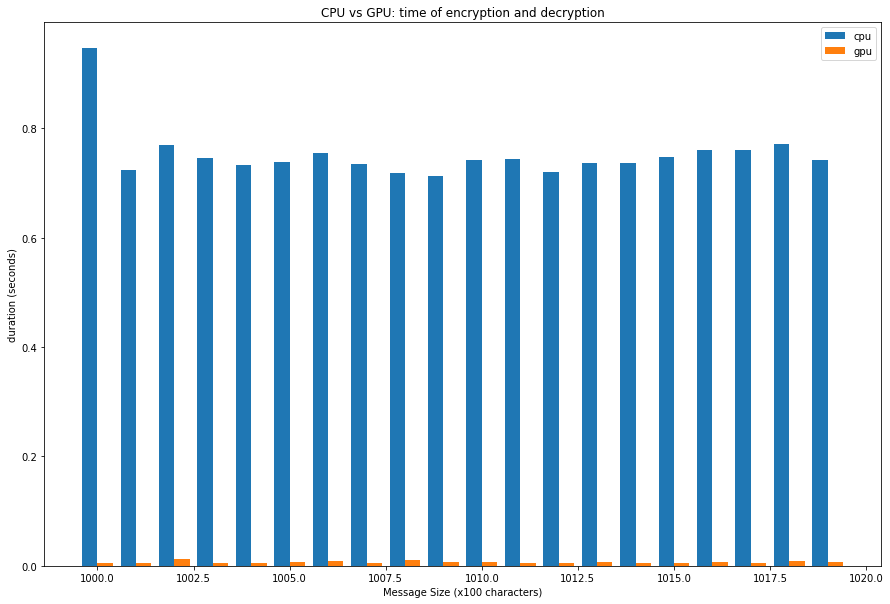

In [52]:
publicKey, privateKey = getRSAKeys(32)

x_axis = sizex100 = np.arange(1000,1020)
y_cpu = []
y_gpu = []

for n in sizex100:
  testMsg = message * n

  encCPU = getEncryptedMssg_cpu(testMsg, publicKey)
  decCPU = getDecryptedMssg_cpu(encCPU['encryptedMssg'], privateKey)
  y_cpu.append(encCPU['cpuTime'] + decCPU['cpuTime'])

  encGPU = getEncryptedMssg_gpu(testMsg, publicKey)
  decGPU = getDecryptedMssg_gpu(encGPU['encryptedMssg'], privateKey)
  y_gpu.append(encGPU['gpuTime'] + decGPU['gpuTime'])


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.bar(x_axis-0.2, y_cpu, width = 0.4, label = "cpu")
plt.bar(x_axis+0.2, y_gpu, width = 0.4, label = "gpu")

plt.xlabel('Message Size (x100 characters)')
plt.ylabel('duration (seconds)')
plt.title('CPU vs GPU: time of encryption and decryption')
plt.legend()
plt.show()